In [107]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

from torch.utils.data import DataLoader

from torchvision.transforms import functional as F 

import torchdata.datapipes as dp 
from torchdata.datapipes import functional_datapipe
from torchdata.datapipes.iter import IterDataPipe

import pytorch_lightning as pl

cuda


In [2]:
DATA = Path("/media/sambhav/30AC4696AC46568E/datasets/building-footprints-dataset")
#DATA = Path("C:/Users/hp/Desktop/datasets/building-footprints-dataset")

TRAIN_DATA = DATA / "labelled" / "patches"
TRAIN_IMAGES = TRAIN_DATA / "images"
TRAIN_MASKS = TRAIN_DATA / "masks"
TRAIN_CATALOG = DATA / "labelled" / "metadata" / "patches.csv"

TEST_DATA = DATA / "labelled" / "scenes"
TEST_IMAGES = TEST_DATA / "images"
TEST_MASKS = TEST_DATA / "masks"

In [68]:
@functional_datapipe("load_train_example")
class TrainExampleLoader(IterDataPipe):
    def __init__(self, source_datapipe: IterDataPipe, image_prefix:Path , mask_prefix:Path):
        self.source_datapipe = source_datapipe
        self.image_prefix = image_prefix
        self.mask_prefix = mask_prefix

    def __iter__(self):
        for file_name, dataset_name in self.source_datapipe:
            image_path = self.image_prefix / file_name 
            mask_path = self.mask_prefix / file_name
            yield (image_path.as_posix(), 
                   mask_path.as_posix(), 
                   dataset_name)

In [69]:
@functional_datapipe("load_image")
class ImageLoader(IterDataPipe):
    def __init__(self, source_pipe: IterDataPipe):
        self.source_pipe = source_pipe
    
    def __iter__(self):
        for _, file_stream in self.source_pipe:
            image = iio.imread(file_stream, extension=".jpg")
            if image.ndim == 2:
                image = np.expand_dims(image, -1)
            image = torch.from_numpy(image).to(torch.float32)
            yield image

In [70]:
@functional_datapipe("preprocess_image")
class ImagePreprocessor(IterDataPipe):
    normalization_params = {
        #"dataset_name": ((rgb_means), (rgb_std_devs))
        "inria": ((0, 0, 0), (255., 255., 255.)),
        "city-osm": ((1, 1, 1), (.1, .1, .1)),
        "isprs": ((1, 1, 1), (.1, .1, .1)),
    }    

    def __init__(self, image_pipe: IterDataPipe, dataset_pipe: IterDataPipe):
        self.image_pipe = image_pipe
        self.dataset_pipe = dataset_pipe
    
    def __iter__(self):
        for image, dataset_name in zip(self.image_pipe, self.dataset_pipe):
            self.normalize(image, dataset_name)
            yield image
    
    def normalize(self, image, dataset_name):
        F.normalize(tensor = image.permute(2, 0, 1), 
                    mean = self.normalization_params[dataset_name][0], 
                    std = self.normalization_params[dataset_name][1],
                    inplace = True) # type: ignore

In [86]:
catalog = dp.iter.IterableWrapper([TRAIN_CATALOG.as_posix()])
catalog = catalog.open_files().parse_csv(skip_lines = 1)
catalog = catalog.load_train_example(TRAIN_IMAGES, TRAIN_MASKS).shuffle()
image_pipe, mask_pipe, dataset_pipe = catalog.unzip(3) 

mask_pipe = mask_pipe.open_files(mode = 'rb').load_image()
#print(next(iter(mask_pipe)).shape)

image_pipe = image_pipe.open_files(mode = 'rb').load_image()
image_pipe = image_pipe.preprocess_image(dataset_pipe)
#print(next(iter(image_pipe)).shape)
datapipe = image_pipe.zip(mask_pipe)

In [131]:
dl = DataLoader(datapipe, shuffle=True)

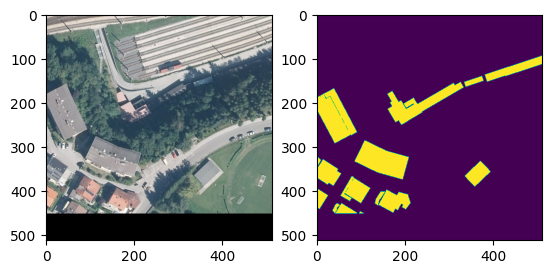

In [135]:
image, mask = next(iter(dl))

plt.subplot(121)
plt.imshow(image[0])

plt.subplot(122)
plt.imshow(mask[0])